# 310.1. Photo-z access and visualization

<div style="max-width:300px; float: left; margin-right: 1em">

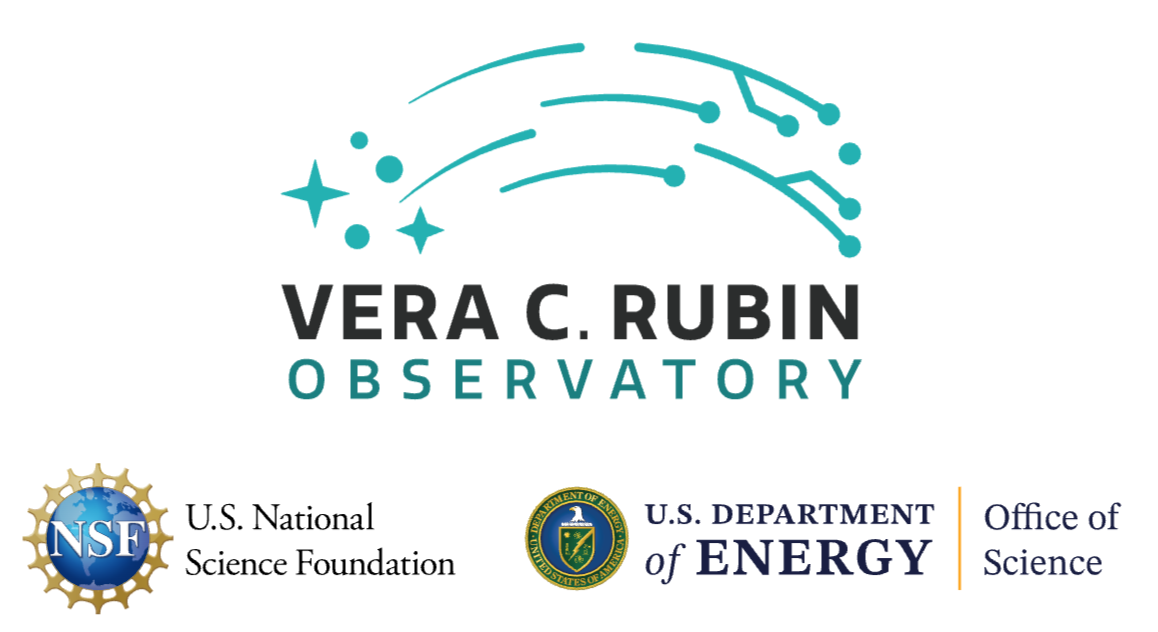

</div>

For the Rubin Science Platform at data.lsst.cloud. <br>
Data Release: <a href="https://dp1.lsst.io/">Data Preview 1</a> <br>
Container Size: Large <br>
LSST Science Pipelines version: Release r29.2.0 <br>
Last verified to run: 2025-09-02 <br>
Repository: <a href="https://github.com/lsst/tutorial-notebooks">github.com/lsst/tutorial-notebooks</a> <br>

**Learning objective:** How to access, cross-match, and visualize the LSDB-formatted photo-z.

**LSST data products:** `Object`

**Packages:** `lsdb`

**Credit:**
Originally developed by the Rubin Community Science team.
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the
<a href="https://community.lsst.org/c/support">Support Category</a>
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

## 1. Introduction

As documented in the SITCom (Systems Integration, Testing, and Commissioning) technical note "Initial studies of photometric redshifts with LSSTComCam from DP1" ([SITCOMTN-154](https://sitcomtn-154.lsst.io/); [Charles et al. 2025](https://ui.adsabs.harvard.edu/abs/2025rubn.rept...35C/abstract)), members of the Rubin Commissioning Science Unit for photometric redshifts have generated photometric redshift (photo-z; PZ) estimates for Data Preview 1 (DP1) objects using a variety of PZ estimators.

The Science Unit team members have made their preliminary PZ results for DP1 objects available in LSDB-formatted files.
[LSDB](https://docs.lsdb.io/) (Large Scale Database) is a python tool for scalable analysis of large catalogs (query and cross-match).
Built on top of [Dask](https://docs.dask.org/), LSDB uses the [HATS](https://hats.readthedocs.io/) (Hierarchical Adaptive Tiling Scheme) data format to efficiently perform spatial operations.
Find LSDB tutorials for accessing Rubin data at [lsdb.io/dp1](lsdb.io/dp1).
Additional information and explanations of different DP1 LSDB data products are available at [data.lsdb.io](data.lsdb.io).
See also the [photo-z page in the DP1 documentation](https://dp1.lsst.io/products/photoz.html).

**These PZ estimates are not necessarily representative of the future LSST-provided PZ in the object table.**
This is due to several reasons.
1. The DP1 observations - and thus the DP1 `Object` photometry - are not fully representative of the future LSST observations (i.e., non-uniform depth across the field, different depths per filter, missing filters for some fields).
2. The input spectroscopic training sets (and other PZ estimator inputs) will be improved and refined in the future.
3. In the future, PZ results will be available as columns in the `Object` table; for DP1 they are only available as separate LSDB catalogs.
4. The choice of which PZ estimator(s) will be used to generate PZ for the LSST `Object` table remains to be determined.

See also "A Roadmap to Photometric Redshifts for the LSST Object Catalog" ([DMTN-049](https://dmtn-049.lsst.io/)).

**This tutorial only demonstrates how to access and visualize the PZ estimates with LSDB.** It does not provide instruction regarding the different PZ estimators or demonstrate how to generate PZ estimates.

**Related tutorials:** The 100-level tutorial on how to access LSDB-formatted files. The 100-level tutorials on the TAP (Table Access Protocol) service, the Butler, and displaying images with Firefly.

### 1.1. Import packages

Import the [LSDB package](https://github.com/astronomy-commons/lsdb/) to work with LSDB-formatted files, along with standard astronomy packages and LSST software for data access.

In [ ]:
import lsdb
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import warnings

from lsst.rsp import get_tap_service
import lsst.afw.display as afwDisplay
from lsst.daf.butler import Butler

### 1.2. Define parameters and functions

Create an instance of the TAP service.

In [ ]:
service = get_tap_service("tap")
assert service is not None

Suppress the user warning that will otherwise be printed by `dask`:

> `/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/dask/dataframe/dask_expr/_collection.py:1435: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting double[pyarrow] to object dtype.`

In [ ]:
warnings.filterwarnings('ignore', category=UserWarning)

Set the backend for `afwDisplay` to be Firefly, and open the Firefly tab.

In [ ]:
afwDisplay.setDefaultBackend("firefly")
afw_display = afwDisplay.Display(frame=1)

Create an instance of the Butler.

In [ ]:
butler = Butler("dp1", collections="LSSTComCam/DP1")
assert butler is not None

## 2. Explore the PZ catalog

Open the read-only LSDB PZ catalog, which has been added by Rubin staff to the `/rubin` directory.

In [ ]:
pz_cat = lsdb.open_catalog("/rubin/lsdb_data/object_photoz")

Display the results.

In [ ]:
pz_cat

**Lazily loaded catalogs:** note the message under the displayed table above, that all of the columns have been loaded "lazily".
This is always the default for LSDB catalogs, and it means that only the metadata is loaded at first.
This way, LSDB can plan how tasks will be executed in the future without actually doing any computation.

### 2.1. Column names

The columns of the LSDB PZ catalog include:

* the `objectId`, `coord_ra`, `coord_dec`
* photometry measurements for each filter `f_` (*ugrizy*):
  * `f_cModelMag` and `f_cModelMagErr`
  * `f_gaap1p0Mag` and `f_gaap1p0MagErr`
  * `f_gaap3p0Mag` and `f_gaap3p0MagErr`
  * `f_kronMag` and `f_kronMagErr`
  * `f_psfMag` and `f_psfMagErr`
* standardized outputs from the PZ estimators

Option to display all 130 column names.

In [ ]:
# pz_cat.all_columns

Print the names of each of the PZ estimators.

In [ ]:
for col in pz_cat.columns:
    if col.find('z_median') >= 0:
        print(col.split('_')[0])

The same standardized PZ point-estimates are provided for all PZ codes.

For a given PZ estimator, show all columns associated with it (use LePhare for this example).

In [ ]:
for col in pz_cat.columns:
    if col.find('lephare') >= 0:
        print(col)

### 2.2. Sky partitions

When `pz_cat` is displayed (above) there are four rows, one for each of the partitions of the LSDB PZ catalog.
These partitions are how the LSDB-formatted files are stored, with each partition typically having about the same number of objects.

Show the four partitions of `pz_cat` on the sky.
This is not necessarily the same as a sky coverage map, but rather shows the file's polygonal partition boundaries.

In [ ]:
fig = pz_cat.plot_pixels(plot_title="Sky Partition Map")

> **Figure 1:** The sky partitions of the lazily-loaded PZ catalog.

### 2.3. Table data

Show the first 10 rows of the PZ catalog.

In [ ]:
pz_cat.head(n=10)

### 2.4. Plot N(pz)

$N(pz)$ refers to a histogram of the number of objects, $N$, as a function of photo-z, $pz$.

In order to find out and visualize which fields have PZ, and get an initial sense of how the PZ results vary by estimator, for each DP1 field plot the histogram N(pz) for $0<pz<3$ for each PZ estimator.

Define the field names and central coordinates in degrees.

In [ ]:
field_centers = {"47 Tuc": [6.02, -72.08],
                 "SV 38 7": [37.86, 6.98],
                 "Fornax": [40.00, -34.45],
                 "ECDFS": [53.13, -28.10],
                 "EDFS": [59.10, -48.73],
                 "SV 95 -25": [95.00, -25.00],
                 "Seagull": [106.23, -10.51]}

Retrieve the names of the 8 PZ estimators with a median PZ column and store them in array `all_pz_codes`.

In [ ]:
all_pz_codes = []
for col in pz_cat.columns:
    if col.find('z_median') >= 0:
        all_pz_codes.append(col.split('_')[0])

Create the histograms. Plots with no data (a flat histogram) represent fields without PZ.

In [ ]:
for field in field_centers.keys():
    coords = field_centers[field]
    pz_cat_cone = pz_cat.cone_search(ra=coords[0], dec=coords[1],
                                     radius_arcsec=2.0 * 3600.0)
    fig, ax = plt.subplots(2, 4, figsize=(10, 4))
    ze = 0
    for i in range(2):
        for j in range(4):
            pz_code = all_pz_codes[ze]
            tx = (pz_cat_cone[pz_code+'_z_median'] > 0) & \
                 (pz_cat_cone[pz_code+'_z_median'] < 3)
            ax[i, j].hist(pz_cat_cone[pz_code+'_z_median'][tx],
                          bins=100, histtype='step', color='black')
            ax[i, j].set_title(all_pz_codes[ze])
            ax[i, j].set_xlim([0, 3])
            ze += 1
            del pz_code, tx
    plt.suptitle(field)
    plt.tight_layout()
    del coords, pz_cat_cone, fig

> **Figure 2:** Histograms of the median PZ for each field, and each PZ estimator. The Seagull Nebula, the Fornax dwarf galaxy, and the 47 Tuc globular cluster fields do not have PZ estimates for their objects, but the rest do. The N(z) distributions for each PZ estimator are different.

Clean up before Section 3.

In [ ]:
del field_centers, pz_cat

## 3. Abell 360

Use the known rich galaxy cluster Abell 360 in the Low Ecliptic Latitude Field (also called `Rubin SV 38 7`) to demonstrate addition functionality of the LSDB PZ catalogs.

Define the central coordinates (RA, Dec) of the brightest cluster galaxy for Abell 360 (in degrees),
and its known redshift ($z=0.22$).

In [ ]:
ra_a360 = 37.865
dec_a360 = 6.982
z_a360 = 0.22

### 3.1. Select columns

Select 12 of the 130 columns to retrieve.

In [ ]:
use_columns = ["objectId", "r_cModelMag", "i_cModelMag", "z_cModelMag"]
for code in all_pz_codes:
    use_columns.append(code + '_z_median')
use_columns

Open the catalog using only the selected columns.

In [ ]:
pz_cat = lsdb.open_catalog("/rubin/lsdb_data/object_photoz",
                           columns=use_columns)

In [ ]:
pz_cat

### 3.2. Cone search

Execute a cone search on `pz_cat` using the coordinates of Abell 360 and a radius of 0.1 deg.

In [ ]:
pz_cat_a360 = pz_cat.cone_search(ra=ra_a360, dec=dec_a360,
                                 radius_arcsec=0.1 * 3600.0)

This table has only 1 partition, compared to 4 as in Section 3.1 because of the spatial limitation of 0.1 deg.

In [ ]:
pz_cat_a360

Option to show the data for the first 10 rows.

In [ ]:
# pz_cat_a360.head(n=10)

### 3.3. Visualizations

Use the `plot_pixels` method to display the sky partition map, as in Section 2.2.

In [ ]:
fig = pz_cat_a360.plot_pixels(plot_title="Abell 360 Sky Partition Map")

> **Figure 3:** Similar to Figure 1 in Section 2.2, but for the one sky partition overlapping Abell 360.

Use the `plot_points` method to mark the location of each object in `pz_cat_a360`, and color the points by the photo-z `knn_z_median`.

In [ ]:
center = SkyCoord(ra_a360 * u.deg, dec_a360 * u.deg)
fig, ax = pz_cat_a360.plot_points(fov=(0.2 * u.deg, 0.25 * u.deg), center=center,
                                  s=3, cmap='viridis', vmin=0.0, vmax=1,
                                  color_col="knn_z_median")

> **Figure 4:** The default coordinate scatter plot with a PZ colorbar.

Same as above, but color the points by the i-band apparent magnitude `i_cModelMag`.

In [ ]:
fig, ax = pz_cat_a360.plot_points(fov=(0.2 * u.deg, 0.25 * u.deg),
                                  center=center, s=3, cmap='viridis',
                                  color_col="i_cModelMag")

> **Figure 5:** The default coordinate scatter plot with an i-band magnitude colorbar.

Similar to Figure 2 in Section 2.4, plot the N(pz) histograms for each of the eight PZ estimators, but only for galaxies within 0.1 deg of Abell 360.

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(10, 4))
ze = 0
for i in range(2):
    for j in range(4):
        pz_code = all_pz_codes[ze]
        tx = (pz_cat_a360[pz_code+'_z_median'] > 0) & \
             (pz_cat_a360[pz_code+'_z_median'] < 3)
        ax[i, j].hist(pz_cat_a360[pz_code+'_z_median'][tx],
                      bins=100, histtype='step', color='black')
        ax[i, j].axvline(0.22, lw=1, ls='solid', color='dodgerblue')
        ax[i, j].set_title(all_pz_codes[ze])
        ax[i, j].set_xlim([0, 3])
        ze += 1
        del pz_code, tx
plt.suptitle('Abell 360')
plt.tight_layout()

> **Figure 6:** Similar to Figure 2, but only for the Abell 360 region. The vertical blue line marks $z=0.22$, the known redshift of Abell 360.

### 3.4. Red sequence galaxies

The tutorial notebook in this series (304 Cosmology) that focuses on the red sequence (RS) of Abell 360 demonstrates that the RS has a color of $r-i \sim 0.5$ mag and $i-z \sim 0.25$ mag. As in that tutorial, use a RS width of $\pm 0.1$ mag, and restrict to galaxies brighter than $i=23$ mag to define the RS-like galaxies.

In [ ]:
pz_cat_a360_rs = pz_cat_a360.query("r_cModelMag - i_cModelMag > 0.4 "
                                   "and r_cModelMag - i_cModelMag < 0.6 "
                                   "and i_cModelMag - z_cModelMag > 0.15 "
                                   "and i_cModelMag - z_cModelMag < 0.35 "
                                   "and i_cModelMag < 23")

In [ ]:
# pz_cat_a360_rs

Plot the PZ histogram for all galaxies within 0.1 deg of Abell 360, and only those that have RS-like colors and magnitudes.

In [ ]:
fig = plt.figure(figsize=(6, 4))
plt.axvline(z_a360, lw=5, alpha=0.5, color='grey', label='z=0.22')
plt.hist(pz_cat_a360['knn_z_median'], bins=300, histtype='step',
         ls='dashed', color='black', label='all galaxies')
plt.hist(pz_cat_a360_rs['knn_z_median'], bins=25, histtype='step',
         color='darkorange', label='RS-like galaxies')
plt.xlim([0, 2])
plt.xlabel('photo-z')
plt.ylabel('number of galaxies')
plt.legend(loc='upper right')
plt.show()

> **Figure 7:** The photo-z distribution of all galaxies within a 0.1 deg radius of Abell 360 (black dashed) compared to only those with r-i and i-z colors consistent with the red sequence of Abell 360 (orange solid), with the known redshift of Abell 360, $z=0.22$, as a thick vertical grey line.

### 3.5. Merge with a TAP table

An LSDB catalog can be merged with a table of DP1 data obtained via the TAP service so long as they have an identifier column, such as `objectId`, in common.

Use the TAP service to retrieve all objects within 0.1 deg of Abell 360. This will include stars and galaxies.

Include the `objectId` column, plus the sky and pixel coordinates and the extendedness parameter.

In [ ]:
query = "SELECT objectId, coord_ra, coord_dec, x, y, refExtendedness " \
        "FROM dp1.Object " \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " \
        "CIRCLE('ICRS', %f, %f, %f)) = 1 "%(ra_a360, dec_a360, 0.1)
print(query)

In [ ]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()

In [ ]:
assert job.phase == 'COMPLETED'
obj_cat = job.fetch_result().to_table().to_pandas()
assert len(obj_cat) == 6464
print(len(obj_cat))

Option to show `obj_cat`.

In [ ]:
# obj_cat

The `lsdb.from_dataframe` method requires that columns named "ra" and "dec" exist, so rename the coordinate columns and then convert to an `lsdb` data frame.

In [ ]:
obj_cat_rename = obj_cat.rename(columns={'coord_ra': 'ra', 'coord_dec': 'dec'})
obj_cat_lsdb = lsdb.from_dataframe(obj_cat_rename)
del obj_cat_rename

In [ ]:
obj_cat_lsdb

Option to display the first 10 rows of `obj_cat_lsdb`.

In [ ]:
# obj_cat_lsdb.head(n=10)

Use the `merge` method to do an "inner" merge on the shared column `objectId`. An "inner" merge means the resulting catalog, `merge_cat`, only contains objects that appear in both `obj_cat_lsdb` and `pz_cat_a360`.

In [ ]:
merge_cat = pz_cat_a360.merge(obj_cat_lsdb, how='inner', on='objectId')

Option to display the first 10 rows of `merge_cat`.

In [ ]:
# merge_cat.head(n=10)

### 3.6. Mark galaxies on image

Use the pixel coordinates `x` and `y`, retrieved from the `Object` table with the TAP service, to mark RS-like galaxies on a `deep_coadd` image retrieved using the Butler.

Do a query on `merge_cat` for RS-like galaxies.

In [ ]:
merge_cat_rs = merge_cat.query("r_cModelMag - i_cModelMag > 0.4 "
                               "and r_cModelMag - i_cModelMag < 0.6 "
                               "and i_cModelMag - z_cModelMag > 0.15 "
                               "and i_cModelMag - z_cModelMag < 0.35 "
                               "and i_cModelMag < 23")

Do a query on `merge_cat_rs` for RS-like galaxies that have a KNN PZ consistent with the histogram for Abell 360 in Figure 7.

In [ ]:
merge_cat_rs_pz = merge_cat_rs.query("knn_z_median > 0.2 and knn_z_median < 0.3")

Retrieve the i-band `deep_coadd` image for the coordinates of Abell 360 from the Butler.

In [ ]:
band = "i"
dataset_refs = butler.query_datasets("deep_coadd",
                                     where="band.name = band AND \
                                     patch.region OVERLAPS POINT(ra, dec)",
                                     bind={"band": band,
                                           "ra": ra_a360,
                                           "dec": dec_a360})
deep_coadd = butler.get(dataset_refs[0])

Display the `deep_coadd` image in the Firefly window, which will automatically open when the following cell is executed.

In [ ]:
afw_display.mtv(deep_coadd)
afw_display.setMaskTransparency(100)

Get the bounding box (`bbox`) for the `deep_coadd` image.

In [ ]:
bbox = deep_coadd.getBBox()

For objects in `merge_cat_rs` with `x` and `y` values within the `bbox`, mark with a red circle.

In [ ]:
tx = merge_cat_rs["x"] < (bbox.getMaxX()-100)
tx &= merge_cat_rs["y"] < (bbox.getMaxY()-100)
xvals = merge_cat_rs["x"][tx]
yvals = merge_cat_rs["y"][tx]
with afw_display.Buffering():
    for xval, yval in zip(xvals, yvals):
        afw_display.dot("o", xval, yval,
                        size=20, ctype="red")
del tx, xvals, yvals

For objects in `merge_cat_rs_pz` with `x` and `y` values within the `bbox`, mark with a red X.

In [ ]:
tx = merge_cat_rs_pz["x"] < (bbox.getMaxX()-100)
tx &= merge_cat_rs_pz["y"] < (bbox.getMaxY()-100)
xvals = merge_cat_rs_pz["x"][tx]
yvals = merge_cat_rs_pz["y"][tx]
with afw_display.Buffering():
    for xval, yval in zip(xvals, yvals):
        afw_display.dot("x", xval, yval,
                        size=20, ctype="red")
del tx, xvals, yvals

Zoom in on the Firefly window to better visualize which objects are marked with both circles and Xs.


<div style="max-width:300px">

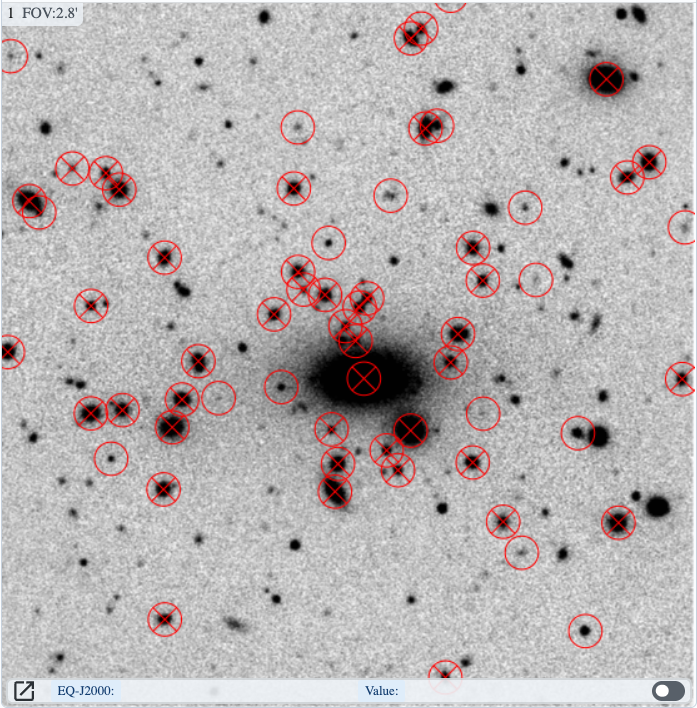

</div>

> **Figure 8:** A screenshot of the Firefly window with galaxies marked, zoomed in on the brightest cluster galaxy of Abell 360.


## 4. Exercises for the learner

Do a query on `merge_cat` for objects that are point-like (have a `refExtendedness == 0`). Mark them on the image with yellow circles of size 10. Find that there is at least one point-like (not extended) object with a RS-like color and photo-z (i.e., is marked with a red circle and x and a yellow circle). Hint: 2h 31m 32.0s, +6d 59m 13.4s.